# Phase-resolved turbulent dissipation

In [79]:
# Imports
import os
import glob
import numpy as np
import pandas as pd
import xarray as xr
from tqdm.notebook import tqdm
from scipy import optimize
from scipy.signal import detrend
import cmocean
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import colors
import matplotlib.dates as mdates
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap
import matplotlib.ticker as tck
from roxsi_pyfuns.plotting import multiple_formatter
from datetime import datetime as DT
from cftime import date2num, num2date
# Interactive plots
%matplotlib widget 

from roxsi_pyfuns import coordinate_transforms as rpct
from roxsi_pyfuns import wave_spectra as rpws
from roxsi_pyfuns import zero_crossings as rpzc
from roxsi_pyfuns import transfer_functions as rptf
from roxsi_pyfuns import plotting as rppl

# Paths
rootdir = r'/media/mikapm/T7 Shield/ROXSI/Asilomar2022/SmallScaleArray/'
vec_root = os.path.join(rootdir, 'Vectors', 'Level1')
figdir = os.path.join(vec_root, 'img')
bathydir = os.path.join(rootdir, 'Bathy')
fn_bathy = os.path.join(bathydir, 'Asilomar_2022_SSA_bathy.nc')
dsbat = xr.decode_cf(xr.open_dataset(fn_bathy, decode_coords='all'))


## 20-min test case
Use C3 Vector as test case.

Flipping y axis ...
ucs-uw phase at max coh: -102.41


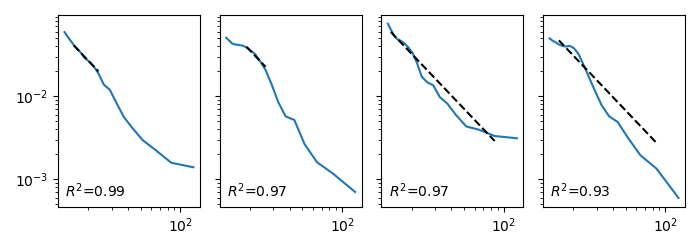

In [209]:
# Serial numbers and corresponding mooring IDs
ser = '17219'
mid = 'C3'
fs = 16 # Sampling freq
# Sample period
t0 = pd.Timestamp('2022-07-17 12:00:00')
t1 = t0 + pd.Timedelta(hours=1)
# Define expected headings in PCA coordinates for C2 & C3
heading_exp = {'C2': -125, 'C3': -90}

# Read netcdf file
ncdir = os.path.join(vec_root, mid)
fn_vec = os.path.join(ncdir, 'Asilomar_SSA_L1_Vec_{}_{}.nc'.format(ser, 
    str(t0.strftime('%Y%m%d'))))
dsv = xr.decode_cf(xr.open_dataset(fn_vec, decode_coords='all'))
# Select sample period
seg = dsv.sel(time=slice(t0, t1))
eta = seg.eta_lin_krms.copy().to_series()

# Convert velocities to cross-/alongshore
# x vel, despiked
uxd = seg.uxd.to_dataframe() # Convert to pandas
uxd = uxd.interpolate(method='bfill').interpolate('ffill')
uxd -= uxd.mean()
# y vel, despiked
uyd = seg.uyd.to_dataframe() # Convert to pandas
uyd = uyd.interpolate(method='bfill').interpolate('ffill')
uyd -= uyd.mean()
# z vel, despiked
uzd = seg.uzd.to_dataframe() # Convert to pandas
uzd = uzd.interpolate(method='bfill').interpolate('ffill')
uzd -= uzd.mean()
# First rotate velocities based on principal axes
vel_pca, R, eul = rpct.rotate_pca(ux=uxd.values.squeeze(), 
                                  uy=uyd.values.squeeze(), 
                                  uz=uzd.values.squeeze(),
                                  return_r=True, return_eul=True, )
# Check if R is left-handed (det(R)=-1) 
if np.linalg.det(R) < 0 and mid in ['C2', 'C3']: 
    # Check if heading is off relative to expected heading
    if np.abs(heading_exp[mid] - np.rad2deg(eul['eul3'])) > 45:
        print('Flipping y axis ...')
        # Redo rotation, but flip y axis
        vel_pca, R, eul = rpct.rotate_pca(ux=uxd.values.squeeze(), 
                                            uy=uyd.values.squeeze(), 
                                            uz=uzd.values.squeeze(),
                                            return_r=True, 
                                            return_eul=True, 
                                            flipy=True,
                                            ) 
# Rotate using Euler angles (C2 and C3)
#             if mid != 'C4':
#                 # Only use PCA heading for C2 and C3
#                 vel_pca, _ = rpct.rotate_euler(ux=uxd.values.squeeze(), 
#                                                uy=uyd.values.squeeze(), 
#                                                uz=uzd.values.squeeze(),
#                                                eul1=np.deg2rad(pitch_mean), 
#                                                eul2=np.deg2rad(roll_mean), 
#                                                eul3=eul['eul3'])
# Assume u_pc1=ucs, u_pc2=uls, u_pc3=uw
ucs = vel_pca[:,0].copy()
uls = vel_pca[:,1].copy()
uw = vel_pca[:,2].copy()
# Check if some component(s) need to be flipped
if np.abs(np.rad2deg(eul['eul1'])) > 90:
    # z-axis points downward -> flip vertical velocity
    print('Flipping vertical velocity ... ')
    uw *= (-1)
if np.abs(np.rad2deg(eul['eul2'])) > 90:
    # z-axis points downward -> flip vertical velocity
    print('Flipping vertical velocity ... ')
    uw *= (-1)
# Check if heading is off if det(R) = 1
if np.linalg.det(R) > 0 and mid in ['C2', 'C3']:
    if np.abs(heading_exp[mid] - np.rad2deg(eul['eul3'])) > 90:
        print('Flipping horizontal velocity ... ')
        ucs *= (-1)
# Compute coherence and phase to check components
spec_r = rpws.spec_uvz(z=uw, u=ucs, v=uls, fs=16)
# Get index of max. coherence^2 b/w ucs and uw
ind_mcu = np.argmax((spec_r.coh_uz**2).sel(freq=slice(0.05, 0.3)).values).item()
ind_mcv = np.argmax((spec_r.coh_vz**2).sel(freq=slice(0.05, 0.3)).values).item()
# Compute ucs-uw phase at max coherence
pmc = np.rad2deg(spec_r.ph_uz.sel(freq=slice(0.05, 0.3)).isel(freq=ind_mcu).item())
# If phase is +90 -> flip ux velocity
if pmc > 0:
    ucs *= (-1)
    # Compute coherence and phase again
    spec_r = rpws.spec_uvz(z=uw, u=ucs, v=uls, fs=16)
    pmc = np.rad2deg(spec_r.ph_uz.sel(freq=slice(0.05, 0.3)).isel(freq=ind_mcu).item())
# Print ucs-uw phase at max coherence
print('ucs-uw phase at max coh: {:.2f}'.format(pmc))

# Get zero-crossings, min. 4-sec waves
zc, Hw, Hc, Ht = rpzc.get_waveheights(eta.values, method='up', minlen=4*16)
# Compute H(1/3)
Hws = np.sort(Hw) # Sorted wave heights
H13 = np.mean(Hws[2*(len(Hw)//3):]) # Mean of highest 1/3 of waves
# Define phase (x) axis to interpolate to
x_phase = np.linspace(0, 2*np.pi, 160)

# Define number of sub-segments per wave cycle (should be even)
ncyc = 4
# Lists for storing dataframes of spectral segments for merging
dfs_lists = {'dfs{}'.format(n): [] for n in range(1,ncyc+1)}
# Interpolate eta, u_cs and w for each wave to wave phase (0-2*pi)
for zi,zc0 in enumerate(zc[:-1]):
    # Only include waves with T > 8 sec
    Tw = (eta.index[zc[zi+1]] - eta.index[zc[zi]]).total_seconds()
    if Tw < 5:
        continue
    # Wave surface elevation, u and w for current wave
    eta_wave = eta.iloc[zc0:zc[zi+1]]
    u_wave = ucs[zc0:zc[zi+1]]
    v_wave = uls[zc0:zc[zi+1]]
    w_wave = uw[zc0:zc[zi+1]]
    # Define phase x axis of wave
    x_wave = np.linspace(0, 1, len(eta_wave)) * 2*np.pi
    # Interpolate to regular phase
    eta_interp = np.interp(x_phase, x_wave, eta_wave.squeeze())
    u_interp = np.interp(x_phase, x_wave, u_wave.squeeze())
    v_interp = np.interp(x_phase, x_wave, v_wave.squeeze())
    w_interp = np.interp(x_phase, x_wave, w_wave.squeeze())

    # Estimate spectra for 1/ncyc wave cycles
    nsub = 160 // ncyc
    # Frequencies
    n_freqs = int(np.floor(nsub / 2 )) # No. of frequency bands
    # Calculate Nyquist frequency and bandwidth (freq. resolution)
    nyquist = 0.5 * fs # Max spectral frequency
    bandwidth = nyquist / n_freqs
    # Find middle of each frequency band, only works when
    # merging odd number of bands
    f = 1/nsub + bandwidth/2 + bandwidth*np.arange(n_freqs)
    # Initialize dict to store spectral dataframes
    dfs = {}
    for i in range(ncyc):
        # Get short-segment velocities
        useg = u_interp[i*nsub:(i+1)*nsub]
        vseg = v_interp[i*nsub:(i+1)*nsub]
        wseg = w_interp[i*nsub:(i+1)*nsub]
        # FFT of vertical velocity segment
        fft_win = np.fft.fft(detrend(wseg))
        # Power spectrum
        ps_win = 2 * np.real(fft_win[:len(wseg)//2] * np.conj(fft_win[:len(wseg)//2]))
        # Compute mean current and check that U >> dU for segment
        U = np.sqrt(np.mean(useg)**2 + np.mean(vseg)**2).item() # Mean orb. vel. mag.
        umag = np.sqrt(useg**2 + vseg**2) # Orb. vel. magnitude, not mean
        dU = np.std(umag) # Variability in umag (following George et al., 1994)
        if (U / dU) < 3:
            # U vs. dU ratio (Eq (6) of George et al., 1994) too small
            continue
        # Convert from f-space to k-space using Eq. (3) of George et al. (1994)
        k = (2*np.pi * f) / U # Wavenumber array
        ps_k = ps_win / (2*np.pi / U) # Wavenumber spectrum
        # Interpolate spectrum to specified frequency range for averaging
        ki = 2 * np.pi / np.linspace(0.5, 0.05, int(n_freqs)) # Interp. k
        ps_i = np.interp(ki, k, ps_k)
        # Save k-spectrum to dataframe and dict
        dfs['q{}'.format(i+1)] = pd.DataFrame(data=ps_i, index=ki)
    # Save dataframes to list for merging
    for n in range(1, ncyc+1):
        if 'q{}'.format(n) in dfs.keys():
            dfs_lists['dfs{}'.format(n)].append(dfs['q{}'.format(n)])

    # Test plot, timeseries
    plot1 = False # Set to True to plot
    if plot1:
        fig, axes = plt.subplots(figsize=(7,5), nrows=2, sharey=True)
        # Plot original time series on top
        axes[0].plot(eta_wave.index, eta_wave.values, c='k', label=r'$\eta$')
        axes[0].plot(eta_wave.index, u_wave, c='r', label=r'$u$')
        axes[0].plot(eta_wave.index, v_wave, c='b', label=r'$v$')
        axes[0].plot(eta_wave.index, w_wave, c='brown', label=r'$w$')
        # Set ticks every second
        axes[0].xaxis.set_major_locator(mdates.SecondLocator(interval=2))
        # Plot interpolated signals on bottom row
        axes[1].plot(x_phase, eta_interp, c='k', label=r'$\eta$')
        axes[1].plot(x_phase, u_interp, c='r', label=r'$u$')
        axes[1].plot(x_phase, v_interp, c='b', label=r'$v$')
        axes[1].plot(x_phase, w_interp, c='brown', label=r'$w$')
        # Set x axis labels as multiples of pi
        axes[1].xaxis.set_major_locator(plt.MultipleLocator(np.pi / 2))
        axes[1].xaxis.set_minor_locator(plt.MultipleLocator(np.pi / 12))
        axes[1].xaxis.set_major_formatter(plt.FuncFormatter(multiple_formatter()))
        # Legend, grid
        for ax in axes:
            ax.grid(alpha=0.5)
            ax.legend()
        # Show
        plt.tight_layout()
        plt.show()
    
# Concatenate spectral dataframes
dfs = {}
for n in range(1, ncyc+1):
    dfs['q{}'.format(n)] = pd.concat(dfs_lists['dfs{}'.format(n)], axis=1)

# Fit inertial subrange for each wave phase quartile
def fun(x, c):
    return c * x ** (-5/3)
# Dicts to store curve fit coeff.
popts = {} # Fit coeff.
rsqs = {} # R^2 value for best fit
sid = {} # Optimal start index for fit
eid = {} # Optimal end index for fit
# Iterate over sub-sections
for n in range(1, ncyc+1):
    # Lists to store curve fit coeff.
    popts_i = [] # Fit coeff.
    rsqs_i = [] # R^2 value for best fit
    sid_i = [] # Optimal start index for fit
    eid_i = [] # Optimal end index for fit
    npts = [] # Number of points to fit
    # Iterate over different start/end freq. indices for fit
    sis = np.arange(0, n_freqs//2)
    eis = -np.arange(1, n_freqs//2)[::-1]
    for si in sis:
        for ei in eis:
            N = len(ki[si:ei])
            if N < 5 * ncyc/8:
                # Don't try to fit to less than 5 points
                continue
            # Average spectra
            ps_mean = dfs['q{}'.format(n)].mean(axis=1).values
            # Fit function
            popt, pcov = optimize.curve_fit(fun, ki[si:ei], ps_mean[si:ei])
            # Compute R^2 following example in
            # https://stackoverflow.com/questions/19189362/getting-the-r-squared-value-using-curve-fit
            residuals = ps_mean[si:ei]- fun(ki[si:ei], *popt)
            ss_res = np.sum(residuals**2)
            ss_tot = np.sum((ps_mean[si:ei]-np.mean(ps_mean[si:ei]))**2)
            r_squared = 1 - (ss_res / ss_tot)
            # Save to dict
            popts_i.append(popt[0])
            rsqs_i.append(r_squared)
            sid_i.append(si)
            eid_i.append(ei)
            npts.append(N)
    # Find best fit from R^2 (highest) and fit length (longest)
    max_rsq_ind = np.argmax(rsqs_i)
    # Save parameters corresponding to max R^2
    popts['q{}'.format(n)] = popts_i[max_rsq_ind]
    rsqs['q{}'.format(n)] = rsqs_i[max_rsq_ind]
    sid['q{}'.format(n)] = sid_i[max_rsq_ind]
    eid['q{}'.format(n)] = eid_i[max_rsq_ind]

# Test plot 2, spectra
plot2 = True
if plot2:
    nrows = ncyc//4
    fig, axes = plt.subplots(figsize=(7,2.5*nrows), ncols=4, nrows=nrows,
                             sharex=True, sharey=True)
    # Plot spectra and -5/3 fits
    for n in range(1, ncyc+1):
        si = sid['q{}'.format(n)]
        ei = eid['q{}'.format(n)]
        rsq = rsqs['q{}'.format(n)]
        ax = axes.flat[n-1]
        dfs['q{}'.format(n)].iloc[1:].mean(axis=1).plot(ax=ax)
        ax.loglog(ki[si:ei], fun(ki[si:ei], popts['q{}'.format(n)]), 'k--')
        # Annotate R^2
        ax.annotate(r'$R^2$='+'{:.2f}'.format(rsq), xy=(0.05, 0.05), 
                    xycoords='axes fraction')
    # Set log-log axes
    for ax in axes.flat:
        ax.set_xscale('log')
        ax.set_yscale('log')
    plt.tight_layout()
    plt.show()



In [206]:
rsqs_i[max_rsq_ind]
dfs.keys()

dict_keys(['q1', 'q3'])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


r_sq: -0.74


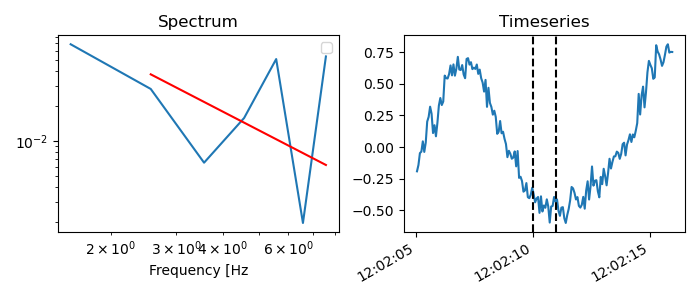

In [104]:
# Spectral segment start
t0s = t0 + pd.Timedelta(minutes=2, seconds=10)
dt = 1 # Spectral segment length, sec
seg = dsv.uU.sel(time=slice(t0s, t0s+pd.Timedelta(seconds=dt)))

# Spectrum estimation
fs = 16 # Sampling freq
# FFT of segment
fft_win = np.fft.fft(seg.values - np.mean(seg.values))
# Frequencies
n_freqs = int(np.floor(len(fft_win) / 2 )) # No. of frequency bands
# Calculate Nyquist frequency and bandwidth (freq. resolution)
nyquist = 0.5 * fs # Max spectral frequency
bandwidth = nyquist / n_freqs
# Find middle of each frequency band, only works when
# merging odd number of bands
f = 1/len(seg) + bandwidth/2 + bandwidth*np.arange(n_freqs)
ps_win = 2 * np.real(fft_win[:len(seg)//2] * np.conj(fft_win[:len(seg)//2]))

# Fit inertial subrange
def fun(x, c):
    return c * x ** (-5/3)

popt, pcov = optimize.curve_fit(fun, f[2:], ps_win[2:])
residuals = ps_win[2:]- fun(f[2:], *popt)
ss_res = np.sum(residuals**2)
ss_tot = np.sum((ps_win[2:]-np.mean(ps_win[2:]))**2)
r_squared = 1 - (ss_res / ss_tot)
print('r_sq: {:.2f}'.format(r_squared))

# Plot
fig, axes = plt.subplots(figsize=(7,3), ncols=2)
# Plot spectrum
axes[0].loglog(f[1:], ps_win[1:])
# Plot -5/3 tail
# axes[0].loglog(f[2:], f[2:]**(-5/3)*10, color='k', linestyle='--', label=r'$f^{-5/3}$')
# Plot fit
axes[0].loglog(f[2:], fun(f[2:], popt[0]), 'r-')
axes[0].set_xlabel('Frequency [Hz')
axes[0].set_title('Spectrum')
axes[0].legend()
# Plot segment time series
dts = 5 # +/- dt for plot segment
pseg = dsv.uE.sel(time=slice(t0s-pd.Timedelta(seconds=dts), 
                             t0s+pd.Timedelta(seconds=dt)+pd.Timedelta(seconds=dts)))
pseg.plot(ax=axes[1])
# Mark segment period
axes[1].axvline(t0s, color='k', linestyle='--')
axes[1].axvline(t0s+pd.Timedelta(seconds=dt), color='k', linestyle='--')
axes[1].set_xlabel(None)
axes[1].set_ylabel(None)
axes[1].set_title('Timeseries')
plt.tight_layout()
plt.show()

In [50]:
def fun(x, c):
    return c * x ** (-5/3)

popt, pcov = optimize.curve_fit(fun, f[1:], ps_win[1:])
residuals = ps_win[1:]- fun(f[1:], *popt)
ss_res = np.sum(residuals**2)
ss_tot = np.sum((ps_win[1:]-np.mean(ps_win[1:]))**2)
r_squared = 1 - (ss_res / ss_tot)
r_squared

-0.21961480699484004